In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymongo
import os, sys
root_dir = "/home/cs/Documents/pymarl/src"
sys.path = ['/home/cs/Documents/pymarl/src'] + sys.path

In [2]:
from config import mongodb

In [3]:
from config.mongodb import REGISTRY as mongo_REGISTRY
def get_mongo_db_client(conf_name, maxSevSelDelay=5000):    
    mongo_conf = mongo_REGISTRY[conf_name](None, None)
    db_url = mongo_conf["db_url"]
    db_name = mongo_conf["db_name"]
    client = pymongo.MongoClient(db_url, ssl=True, serverSelectionTimeoutMS=maxSevSelDelay)
    return client, client[db_name]

In [4]:
class MongoCentral():
    
    def __init__(self, *args, **kwargs):
        self.conf_names = kwargs["conf_names"]
        self.db = {}
        self._connect(self.conf_names)
        
    def _connect(self, conf_names):
        self.clients = {}
        for _name in conf_names:
            self.clients[_name], self.db[_name] = get_mongo_db_client(_name)
            
    def get_exp_names(self):
        #print("Loading keys...")
        names = []
        for key, db in self.db.items():
            query = db["runs"].distinct("config.name") # .find({"config":None})
            names.extend(query)
            print("Done Loading...")
        return names
    
    def get_tag_names(self, tag, bundle=True):
        import re
        names = []
        for key, db in self.db.items():            
            query = db.runs.find({"config.name":{'$regex':r'^{}(.*)'.format(tag)}}, {"config.name":1}) # .find({"config":None})
            names.extend([_q["config"]["name"] for _q in query])
            print("Done Loading...")
            
        if bundle: # bundle by experiment name
            bundle_dic = {}
            for name in names:
                tag, exp_name_time_stamp, repeat = name.split("__")
                exp_name = "_".join(exp_name_time_stamp.split("_")[:-1])
                if exp_name not in bundle_dic:
                    bundle_dic[exp_name] = []
                bundle_dic[exp_name].append(name) 
            return bundle_dic
        return names

    def get_name_prop(self, name, prop):
        res = []
        for key, db in self.db.items():
            query = db.runs.find({"config.name":name}, {prop:1})
            for _q in query:
                res.append(_q)
        return res

In [5]:
mongo_central = MongoCentral(conf_names=["gandalf_pymarl"])

In [6]:
#a = mongo_central.get_exp_names()
#print(a)
#print("--------------------------")
import pprint
b = mongo_central.get_tag_names("BASE6")
pprint.pprint(b)

Done Loading...
{'coma_baseline_2d_3z': ['BASE6__coma_baseline_2d_3z_01/05/18-19:45:47__repeat1',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:58__repeat1',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:47__repeat2',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:58__repeat2',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:47__repeat3',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:58__repeat4',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:58__repeat5',
                         'BASE6__coma_baseline_2d_3z_01/05/18-19:45:47__repeat5'],
 'coma_baseline_3m': ['BASE6__coma_baseline_3m_01/05/18-19:45:47__repeat1',
                      'BASE6__coma_baseline_3m_01/05/18-19:45:58__repeat1',
                      'BASE6__coma_baseline_3m_01/05/18-19:45:47__repeat2',
                      'BASE6__coma_baseline_3m_01/05/18-19:45:58__repeat2',
                      '

In [7]:
def plot_bundle(bundle, mongo_central, prop, mode = ""): # mode: individual, all
    import pandas as pd
    if mode in ["individual"]:
        # make separate plot for each key, showing all subkeys
        df_dict={}
        for _exp, _names in bundle.items():
            episode_rewards_test = []
            t_env_test = []
            dfs = []
            for _i, _name in enumerate(_names):
                ret = mongo_central.get_name_prop(_name, "info.{}".format(prop))                
                ret2 = mongo_central.get_name_prop(_name, "info.T env test")
                if ret[0]["info"] != {}:
                    episode_rewards_test.append(ret[0]["info"][prop])
                    t_env_test.append(ret2[0]["info"]["T env test"])
                    min_len = min(len(t_env_test[-1]), len(episode_rewards_test[-1]))
                    df  = pd.DataFrame(data=episode_rewards_test[-1][:min_len], 
                                       columns=["{}{}".format(_exp, _i)], 
                                       index=t_env_test[-1][:min_len])
                    dfs.append(df)
                else:
                    #episode_rewards_test.append([])
                    #t_env_test.append([])                    
                    pass
                #print(episode_rewards_test)
                #print(t_env_test)
            total_df = pd.concat(dfs)
            total_df.index = total_df.index.astype(int)
            total_df = total_df.sort_index()
            total_df = total_df.groupby(total_df.index).mean()
            interpol_df = total_df.interpolate(method="nearest")
            interpol_df.plot(title="Experiment: {}".format(_exp),
                            figsize=(20, 10))
            df_dict[_name] = interpol_df
        return df_dict
            #break
            
    elif mode in ["all"]: 
        # plot all keys on same plot, averaging over subkeys

        pass

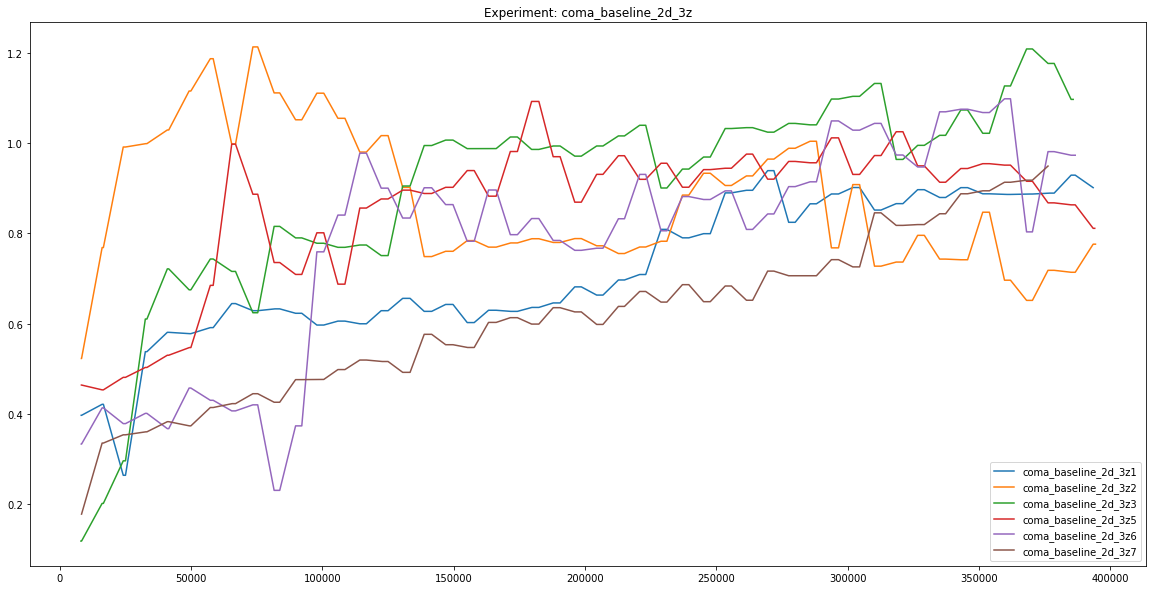

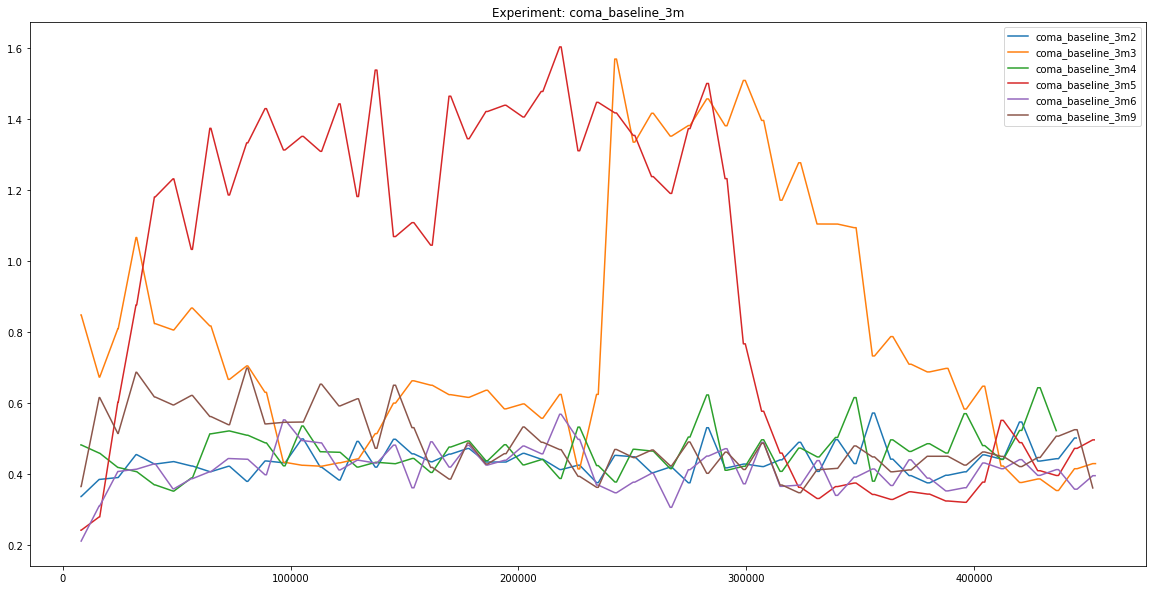

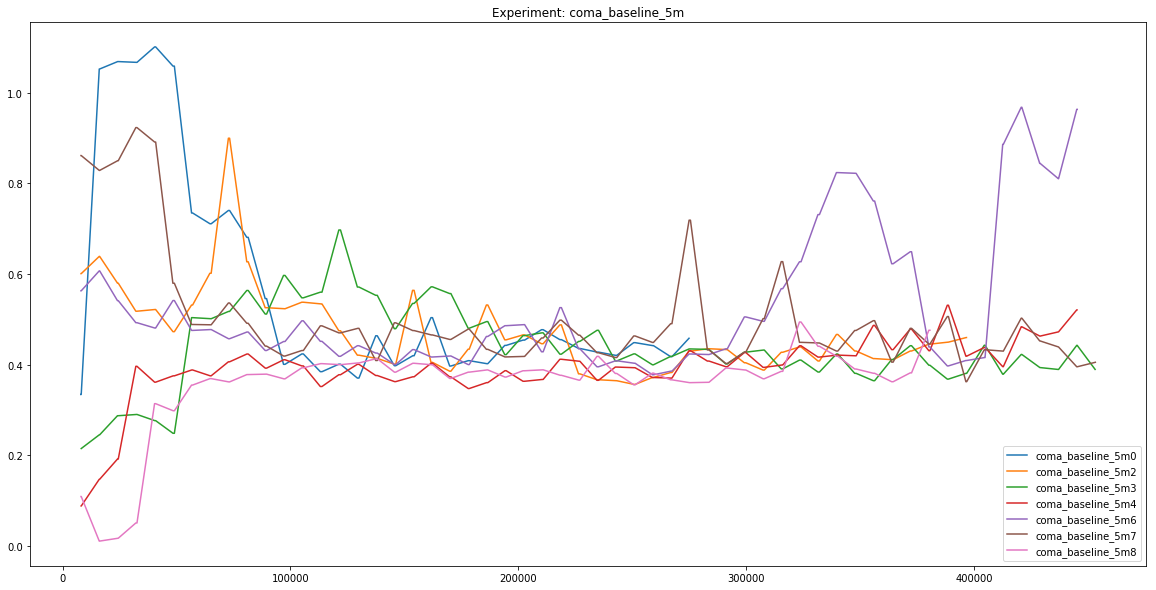

In [8]:
d1 = plot_bundle(b, mongo_central, prop="Episode reward test", mode="individual")

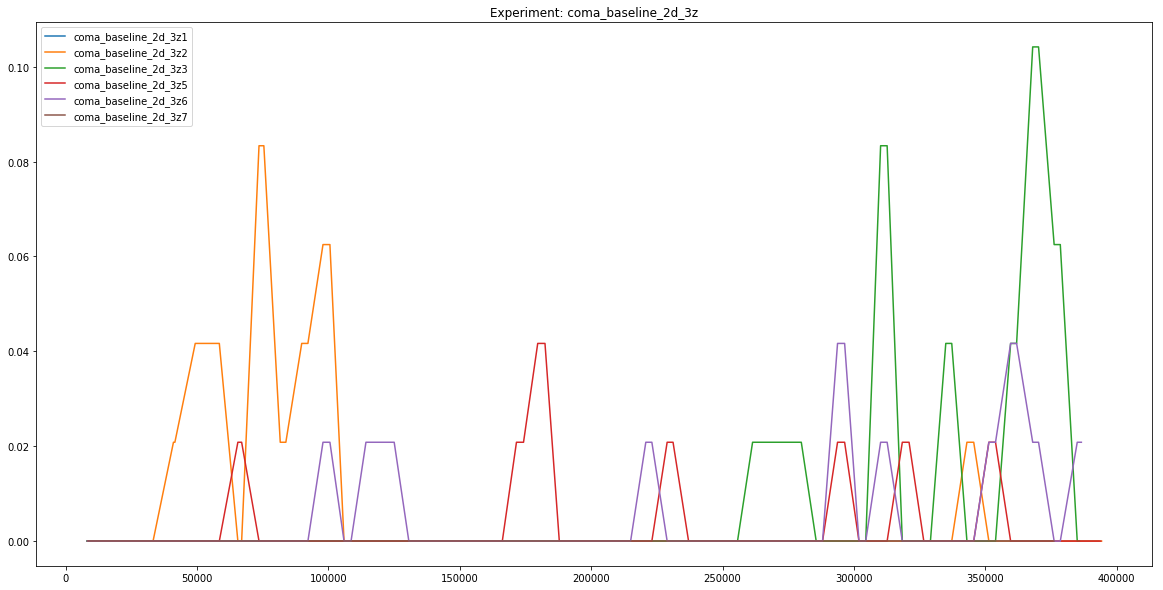

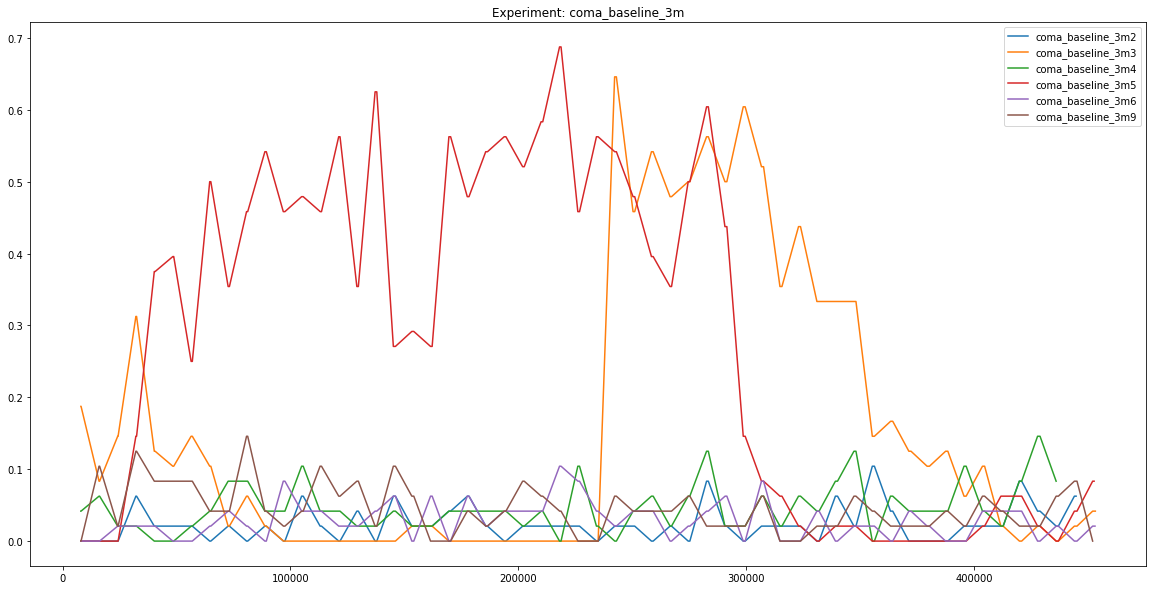

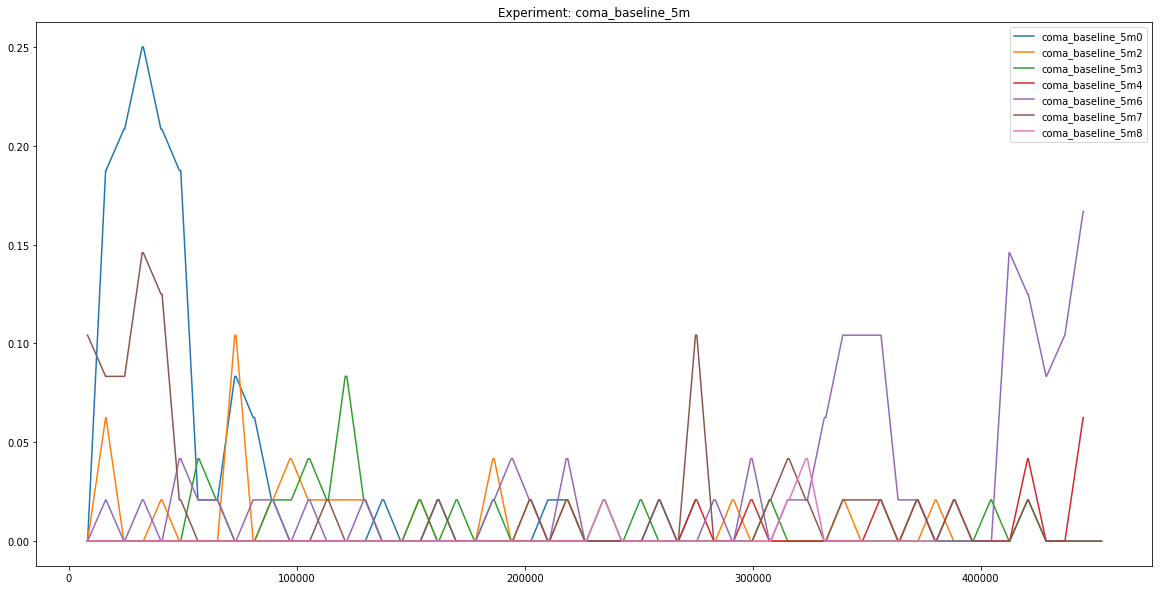

In [9]:
d2 = plot_bundle(b, mongo_central, prop="Win rate test", mode="individual")

In [10]:
# mongo_central.get_name_prop("BASE6__coma_baseline_3m_01/05/18-19:45:58__repeat3", "info")

In [11]:
#import seaborn as sns
#sns.set(style="darkgrid")

def plot_std_tube(df_mean, df_std, color):
    #std = df_std.std(axis=1, skipna=True)
    #mn = df_mean.mean(axis=1, skipna=True)
    pl = mn.plot(title="HELLO", figsize=(20, 10))
    pl.fill_between(mn.index, mn - std,  
                 mn + std, color="#EFF9FC") 

#sns.tsplot(data=, time="timepoint", unit="subject",
#           condition="ROI", value="BOLD signal")